In [12]:
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified


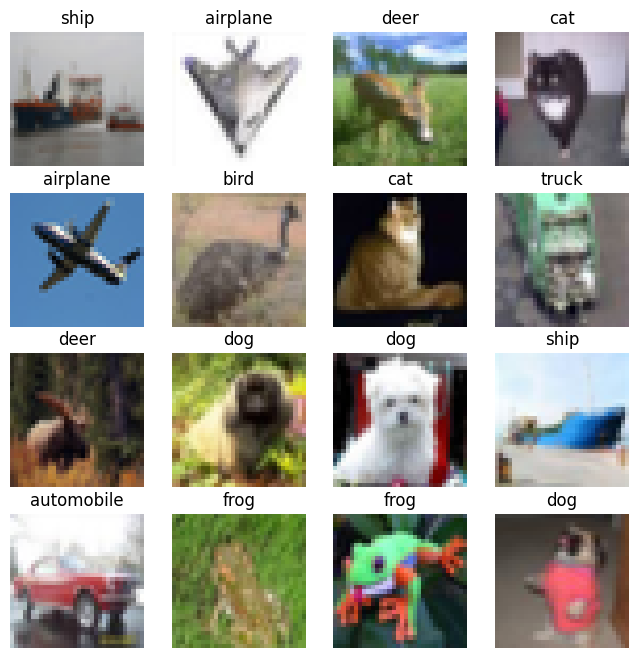

In [13]:
training_data=CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data=CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    img=img.permute(1,2,0)
    plt.imshow(img)
plt.show()

In [14]:
def _extract_tensors(dset, num=None):
  x = torch.tensor(dset.data, dtype=torch.float32).permute(0, 3, 1, 2).div_(255)
  y = torch.tensor(dset.targets, dtype=torch.int64)
  if num is not None:
    if num <= 0 or num > x.shape[0]:
      raise ValueError('Invalid value num=%d; must be in the range [0, %d]' % (num, x.shape[0]))
    x = x[:num].clone()
    y = y[:num].clone()
    return x, y
  
class KNNClassifier:
    def __init__(self,x_train,y_train):
        self.x_train=x_train
        self.y_train=y_train

    @staticmethod
    def compute_distances_two_loops(x_train, x_test):
        num_train = x_train.shape[0]
        num_test = x_test.shape[0]
        dists = x_train.new_zeros(num_train, num_test)
        train = x_train.flatten(1)
        test = x_test.flatten(1)
        print(train.shape)
        print(test.shape)
        for train_idx in range(num_train):
            for test_idx in range(num_test):
                dists[train_idx, test_idx] = torch.sqrt(torch.sum(torch.square(train[train_idx] - test[test_idx])))
        return dists
    
    @staticmethod
    def compute_distances_no_loops(x_train, x_test):
        num_train = x_train.shape[0]
        num_test = x_test.shape[0]
        dists = x_train.new_zeros(num_train, num_test)
        train = x_train.flatten(1)
        test = x_test.flatten(1)
        train_sq = torch.square(train)
        test_sq = torch.square(test)
        train_sum_sq = torch.sum(train_sq, 1)
        test_sum_sq = torch.sum(test_sq, 1)
        mul = torch.matmul(train, test.transpose(0, 1))
        dists = torch.sqrt(train_sum_sq.reshape(-1, 1) + test_sum_sq.reshape(1, -1) - 2*mul)
        return dists

    def predict(self,x_test,k=1):
        y_test_pred=torch.zeros(x_test.shape[0],dtype=torch.int64)
        dists=self.compute_distances_no_loops(self.x_train,x_test)
        for i in range(dists.shape[1]):
            x = torch.topk(dists[:,i], k, largest=False).indices
            k_lowest_labels = self.y_train[x]
            y_test_pred[i] = torch.argmax(torch.bincount(k_lowest_labels))
        return y_test_pred
    
    def check_accuracy(self, x_test, y_test, k=1):
        y_test_pred = self.predict(x_test, k=k)
        num_samples = x_test.shape[0]
        num_correct = (y_test == y_test_pred).sum().item()
        accuracy = 100.0 * num_correct / num_samples
        return accuracy
    
    @staticmethod
    def knn_cross_validate(x_train, y_train, num_folds=5, k_choices=None):
        if k_choices is None:
            k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
        x_train_folds = []
        y_train_folds = []

        x_train_flat = x_train.view(x_train.shape[0], -1)

        x_train_folds = torch.chunk(x_train_flat, num_folds, dim=0)
        y_train_folds = torch.chunk(y_train, num_folds, dim=0)
        k_to_accuracies = {}
        for k in k_choices:
            for folds in range(num_folds):
                x_valid = x_train_folds[folds]
                y_valid = y_train_folds[folds]

                x_traink = torch.cat(x_train_folds[:folds] + x_train_folds[folds + 1:])
                y_traink = torch.cat(y_train_folds[:folds] + y_train_folds[folds + 1:])

                knn = KNNClassifier(x_traink, y_traink)

                accuracy = knn.check_accuracy(x_valid, y_valid, k=k)

                k_to_accuracies.setdefault(k, []).append(accuracy)
        return k_to_accuracies
    
    def knn_get_best_k(self,num_folds=5, k_choices=None):
        k_to_accuracies=self.knn_cross_validate(self.x_train,self.y_train)
        best_k=0
        keys = [k for k in k_to_accuracies.keys()]
        values = [v for v in k_to_accuracies.values()]
        max_avg = torch.argmax(torch.mean(torch.tensor(values), dim=1))
        best_k = keys[max_avg]
        return best_k
    

In [15]:
x_train,y_train=_extract_tensors(training_data, training_data.shape[0])
x_test,y_test=_extract_tensors(test_data, test_data.shape[0])
classifier = KNNClassifier(x_train, y_train)
print(classifier.check_accuracy(x_test, y_test, k=3))
print(classifier.knn_get_best_k(num_folds=5, k_choices=None))

40.0
1
